### 2023.07.07 : TSA_01_(Adfuller_TEST)
- data를 Load 하고 기본적인 transform을 진행하여 모델에 입력 가능하도록 정비한다.

### 2023.07.07 : TSA_01
- Adfuller stationary (Dickey Fuller) Test 확인
- 전체 데이터를 하나의 frame으로 묶어야 하는가?
- transform을 하기 위한 정보 dict 를 만들어야 하는가?

In [ ]:
# colab 한글 font 사용을 위한 font 설치
# install 후 restart session
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (7,676 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123105 files and di

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# os.chdir(r'D:\2023\Sadj\x13as_ascii-v1-1-b59\x13as')
from datetime import datetime as dt
import time

import types
import numpy as np
import pandas as pd
import openpyxl
import pprint as pp

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Python set up modules loaded")
print("Python version:\n", os.sys.version, "\nPlatform: ", os.sys.platform)
print("Base directory path:", os.getcwd())
print("Data/time:", dt.now())

import statsmodels as sma
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12

print("STATSMODELS info (statsmodels._version.version)", sma._version.version)
# v0.13.0 만 json version 정보 있음. v0.14.0 부터 없음.

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
%matplotlib inline
import seaborn as sns

Python set up modules loaded
Python version:
 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0] 
Platform:  linux
Base directory path: /content
Data/time: 2023-07-08 10:10:35.115850
STATSMODELS info (statsmodels._version.version) 0.13.5


In [ ]:
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean()
    iqr = dta.quantile([0.25, 0.75]).diff().T.iloc[:, 1]

    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [ ]:
# 데이터 저장 위치에 excel files  확인
data_path = '/content/drive/MyDrive/ZZ/Code_02/Base_data'
data_list = [file for file in os.listdir(data_path) if file.endswith(".xlsx")]
data_list.sort()
for d, f in enumerate(data_list):
  print(data_list[d], "---", d)

dataset_01.xlsx --- 0
dataset_02.xlsx --- 1
dataset_03_M.xlsx --- 2
dataset_03_Q.xlsx --- 3
변수목록_(선행연구변수).xlsx --- 4
선행연구표.xlsx --- 5


In [ ]:
# dataset_01.xlsx file 안에 있는 sheet에서 사용할 계열(입력 데이터 variable) 확을 위한 sheet 를 load
df_var_info = pd.read_excel(os.path.join(data_path,data_list[1]),sheet_name=0,header=0)
print(df_var_info.head(),"\n")

# dataset variable list
var_list = df_var_info['Variable'].iloc[1:]

Sadj=df_var_info['계절조정'][1:]
x13_arima=df_var_info['X13-arima'][1:]
print(f"전체 사용 변수의 개수 -------------- {len(var_list)}")
print(f"계절조정 된 계열의 개수 ------------ {sum(Sadj == 'o')}")
print(f"계절조정 되지 않은 계열의 개수 ----- {sum(Sadj == 'x')}")
print(f"X13-arima로 계열조정 해야 하는 개수- {sum(x13_arima == 'o')}")

    ID Group    Variable   단위  FEQ  LAG 계절조정 X13-arima               비고  \
0  NaN   NaN         NaN  NaN  NaN  NaN  NaN       NaN              NaN   
1   A1  주요지표  국내총생산(GDP)   %     Q  2.0    o         x  (실질, 계절조정, 전기비)   
2   A2   NaN        민간소비   %     Q  2.0    o         x  (실질, 계절조정, 전기비)   
3   A3   NaN        설비투자   %     Q  2.0    o         x  (실질, 계절조정, 전기비)   
4   A4   NaN        건설투자   %     Q  2.0    o         x  (실질, 계절조정, 전기비)   

   Unnamed: 9  Unnamed: 10  Unnamed: 11  Unnamed: 12 Unnamed: 13  
0         NaN          NaN          NaN          NaN         NaN  
1         NaN          NaN          NaN          NaN         NaN  
2         NaN          NaN          NaN          NaN         NaN  
3         NaN          NaN          NaN          NaN         NaN  
4         NaN          NaN          NaN          NaN         NaN   

전체 사용 변수의 개수 -------------- 102
계절조정 된 계열의 개수 ------------ 41
계절조정 되지 않은 계열의 개수 ----- 61
X13-arima로 계열조정 해야 하는 개수- 61


In [ ]:
dataset_Q = pd.read_excel(os.path.join(data_path,data_list[3]), header=0)
print(dataset_Q.head())
col_Q = dataset_Q.columns
print(f"\n변수의 개수 -------------- {len(col_Q)}")
print(f"데이터의 길이 ------------ {len(dataset_Q)}")
for i, col in enumerate(col_Q):
  print(f"{col}계열의 NaN 개수 ----- {sum(dataset_Q[col].isna())}")

print(f"\n{dataset_Q.head()}")
print(f"\n{dataset_Q.tail()}")

# 실제 데이터와 Quater 기준일이 다름 : x13-arima의 영향으로 보임.

        date   A1   A2    A3    A4    A5    A6
0 1959-06-01  4.5  5.4  15.6   3.5  34.1   1.0
1 1959-09-01 -1.1 -4.0 -14.0 -16.7  -5.5 -25.1
2 1959-12-01  0.6  3.9   2.2 -10.0  17.3   5.7
3 1960-03-01  3.2  0.9   0.6  24.5   5.9   8.9
4 1960-06-01  4.3 -1.0   4.8   1.7  -6.0  14.2

변수의 개수 -------------- 7
데이터의 길이 ------------ 252
date계열의 NaN 개수 ----- 0
A1계열의 NaN 개수 ----- 0
A2계열의 NaN 개수 ----- 0
A3계열의 NaN 개수 ----- 0
A4계열의 NaN 개수 ----- 0
A5계열의 NaN 개수 ----- 0
A6계열의 NaN 개수 ----- 0

        date   A1   A2    A3    A4    A5    A6
0 1959-06-01  4.5  5.4  15.6   3.5  34.1   1.0
1 1959-09-01 -1.1 -4.0 -14.0 -16.7  -5.5 -25.1
2 1959-12-01  0.6  3.9   2.2 -10.0  17.3   5.7
3 1960-03-01  3.2  0.9   0.6  24.5   5.9   8.9
4 1960-06-01  4.3 -1.0   4.8   1.7  -6.0  14.2

          date   A1   A2   A3   A4   A5   A6
247 2021-03-01  0.7 -0.6 -4.2 -2.5  4.2  0.0
248 2021-06-01  0.8  2.9  1.6 -0.6 -2.6 -1.8
249 2021-09-01  0.2  1.6  7.0 -0.1  0.2  5.7
250 2021-12-01 -0.3 -0.5  2.4  1.3 -4.2 -3.9
251 2022-0

In [ ]:
# 계열 time index 및 길이 조정
p_rng = pd.period_range('1960Q2', '2023Q1', freq='Q-FEB')
df_Q = dataset_Q.set_index(p_rng)
df_Q = df_Q.iloc[:,1:].astype('float')
df_Q.index.name = 'date'
df_Q

,A1,A2,A3,A4,A5,A6
date,,,,,,
1960Q2,4.5,5.4,15.6,3.5,34.1,1.0
1960Q3,-1.1,-4.0,-14.0,-16.7,-5.5,-25.1
1960Q4,0.6,3.9,2.2,-10.0,17.3,5.7
1961Q1,3.2,0.9,0.6,24.5,5.9,8.9
1961Q2,4.3,-1.0,4.8,1.7,-6.0,14.2
...,...,...,...,...,...,...
2022Q1,0.7,-0.6,-4.2,-2.5,4.2,0.0
2022Q2,0.8,2.9,1.6,-0.6,-2.6,-1.8
2022Q3,0.2,1.6,7.0,-0.1,0.2,5.7


In [ ]:
dataset_M = pd.read_excel(os.path.join(data_path,data_list[2]),header=0)
print(dataset_M.head())
col_M = dataset_M.columns
print(f"\n변수의 개수 -------------- {len(col_M)}")
print(f"데이터의 길이 ------------ {len(dataset_M)}")
# for i, col in enumerate(col_M):
  # print(f"{col}계열의 NaN 개수 ----- {sum(dataset_M[col].iloc[2:].isna())}")
print(f"\n{dataset_M}")
print(f"\n{dataset_M}")

        date     B7     B8  C9  C10  C11  C12  D13  D14  D15  ...  N93  O94  \
0 1970-01-01  101.0  100.6 NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
1 1970-02-01  100.9  101.5 NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
2 1970-03-01  100.8  101.9 NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
3 1970-04-01  100.6  103.2 NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   
4 1970-05-01  100.5  103.2 NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   

   O95  O96  O97  O98  O99  O100  O101  O102  
0  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
1  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
2  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
3  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  
4  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN  

[5 rows x 97 columns]

변수의 개수 -------------- 97
데이터의 길이 ------------ 642

          date     B7     B8     C9    C10       C11    C12    D13    D14  \
0   1970-01-01  101.0  100.6    NaN    NaN       NaN    NaN    NaN    NaN   
1   1970-02-01

In [ ]:
dataset_M.tail()

,date,B7,B8,C9,C10,C11,C12,D13,D14,D15,...,N93,O94,O95,O96,O97,O98,O99,O100,O101,O102
637,2023-02-01,98.4,99.2,110.1,99.0,106.6054,116.4,97.4,119.0,96.5,...,1.542334,1.907272e+12,1.060365e+10,1.715183e+11,3.798598e+11,2.230366e+10,2.035118e+11,2.402448e+09,8.332057e+07,8.438865e+07
638,2023-03-01,98.2,99.7,111.4,104.2,102.0678,115.8,100.8,118.1,101.3,...,1.484323,1.936017e+12,9.534970e+09,1.838119e+11,3.904909e+11,2.239606e+10,2.538170e+11,2.410658e+09,8.459582e+07,8.527323e+07
639,2023-04-01,98.0,99.9,109.8,102.9,103.3226,115.4,96.2,125.4,100.1,...,NaN,1.959187e+12,1.233861e+10,2.237531e+11,3.938798e+11,2.484373e+10,2.338853e+11,2.422865e+09,8.134959e+07,8.297265e+07
640,2023-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.996649e+12,1.160945e+10,1.777922e+11,3.998285e+11,2.392407e+10,1.851661e+11,2.441096e+09,1.062911e+08,1.067726e+08
641,2023-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 계열 time index 및 길이 조정
# date = pd.to_datetime(dataset_M['date'])
# df_M = dataset_M.iloc[2:].set_index(date)
# df_M = df_M.iloc[:,1:].astype('float')
# df_M.index.name = 'date'
# df_M

# 계열 time index 및 길이 조정
p_rng = pd.period_range('1970-01-01', '2023-06-01', freq='m')
df_M = dataset_M.set_index(p_rng)
df_M = df_M.iloc[:,1:].astype('float')
df_M.index.name = 'date'
df_M

,B7,B8,C9,C10,C11,C12,D13,D14,D15,E16,...,N93,O94,O95,O96,O97,O98,O99,O100,O101,O102
date,,,,,,,,,,,,,,,,,,,,,
1970-01,101.0,100.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02,100.9,101.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03,100.8,101.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04,100.6,103.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05,100.5,103.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02,98.4,99.2,110.1,99.0,106.6054,116.4,97.4,119.0,96.5,107.6,...,1.542334,1.907272e+12,1.060365e+10,1.715183e+11,3.798598e+11,2.230366e+10,2.035118e+11,2.402448e+09,8.332057e+07,8.438865e+07
2023-03,98.2,99.7,111.4,104.2,102.0678,115.8,100.8,118.1,101.3,107.7,...,1.484323,1.936017e+12,9.534970e+09,1.838119e+11,3.904909e+11,2.239606e+10,2.538170e+11,2.410658e+09,8.459582e+07,8.527323e+07
2023-04,98.0,99.9,109.8,102.9,103.3226,115.4,96.2,125.4,100.1,105.2,...,NaN,1.959187e+12,1.233861e+10,2.237531e+11,3.938798e+11,2.484373e+10,2.338853e+11,2.422865e+09,8.134959e+07,8.297265e+07


In [ ]:
# df list
data_list = [ part for part in globals() if part.startswith('df_')]
data_list.sort()
data_list

['df_M', 'df_Q', 'df_var_info']

In [ ]:
# mid term dataset save : 통합 엑셀파일로 중간 저장
save_dir= '/content/drive/MyDrive/ZZ/Code_02/Base_data'
save_file = 'dataset_03_S.xlsx'
save_path = os.path.join(save_dir,save_file)

for f in data_list:
  sheet = '{}'.format(f)
  if not os.path.exists(save_path):
      with pd.ExcelWriter(save_path, mode='w', engine='openpyxl') as writer:
          globals()[f].to_excel(writer, index=True, sheet_name=sheet)
  else:
      with pd.ExcelWriter(save_path, mode='a', engine='openpyxl') as writer:
          globals()[f].to_excel(writer, index=True, sheet_name=sheet)

In [ ]:
# mid read dataset
save_dir= '/content/drive/MyDrive/ZZ/Code_02/Base_data'
save_file = 'dataset_03_S.xlsx'
save_path = os.path.join(save_dir,save_file)

df_Q = pd.read_excel(save_path, sheet_name='df_Q', header=0)
df_M = pd.read_excel(save_path, sheet_name='df_M', header=0)

# 계열 time index 및 길이 조정
p_rng = pd.period_range('1960Q2', '2023Q1', freq='Q-FEB')
df_Q = df_Q.set_index(p_rng)
df_Q = df_Q.iloc[:,1:].astype('float')
df_Q.index.name = 'date'
p_rng = pd.period_range('1970-01-01', '2023-06-01', freq='m')
df_M = df_M.set_index(p_rng)
df_M = df_M.iloc[:,1:].astype('float')
df_M.index.name = 'date'

print(df_Q)
print(df_M)

# df list
data_list = [ part for part in globals() if part.startswith('df_')]
data_list.sort()
data_list

         A1   A2    A3    A4    A5    A6
date                                    
1960Q2  4.5  5.4  15.6   3.5  34.1   1.0
1960Q3 -1.1 -4.0 -14.0 -16.7  -5.5 -25.1
1960Q4  0.6  3.9   2.2 -10.0  17.3   5.7
1961Q1  3.2  0.9   0.6  24.5   5.9   8.9
1961Q2  4.3 -1.0   4.8   1.7  -6.0  14.2
...     ...  ...   ...   ...   ...   ...
2022Q1  0.7 -0.6  -4.2  -2.5   4.2   0.0
2022Q2  0.8  2.9   1.6  -0.6  -2.6  -1.8
2022Q3  0.2  1.6   7.0  -0.1   0.2   5.7
2022Q4 -0.3 -0.5   2.4   1.3  -4.2  -3.9
2023Q1  0.3  0.6  -5.0   1.3   5.1   4.6

[252 rows x 6 columns]
            B7     B8     C9    C10       C11    C12    D13    D14    D15  \
date                                                                        
1970-01  101.0  100.6    NaN    NaN       NaN    NaN    NaN    NaN    NaN   
1970-02  100.9  101.5    NaN    NaN       NaN    NaN    NaN    NaN    NaN   
1970-03  100.8  101.9    NaN    NaN       NaN    NaN    NaN    NaN    NaN   
1970-04  100.6  103.2    NaN    NaN       NaN    NaN    Na

['df_M', 'df_Q']

In [ ]:
# 전체 데이터 adf_test
def adf_test(transformed):
  if (result := adfuller(transformed.values))[1] < 0.05 :
    test_result = "{}".format("S")
  else:
    test_result = "{}".format("N")
  return test_result

save_dir= '/content/drive/MyDrive/ZZ/Code_02/Base_data'
save_file = 'val_adf_test_set_trans_results.xlsx'
save_path = os.path.join(save_dir,save_file)

trans = ['Origin','Diff-1','Log-1','Diff-2']
start = '1960-01'
end = '2023-03'

# data_list.remove('df_var_info')

adf_test_result = []
i = 0

for df in data_list:
   columns = globals()[df].columns
   for col in columns:
      for t in trans:
        i += 1
        print(f"processing....{i}.... [ {df} ------ {col} ------ {t} ---- ]")
        # test
        if t == 'Origin':
          transformed = globals()[df][col].loc[start:end].dropna()
          res = adf_test(transformed)

        elif t == 'Diff-1':
          transformed = globals()[df][col].loc[start:end].diff().dropna()
          res = adf_test(transformed)

        elif t == 'Log-1':
          # error transform log list
          if col in ['A1','A2','A3','A4','A5','A6']:
            res = 'X'
          else:
            log_1 = globals()[df][col].loc[start:end]
            transformed = np.log(log_1).dropna()
            res = adf_test(transformed)

        elif t == 'Diff-2':
          transformed = globals()[df][col].loc[start:end].diff().diff().dropna()
          res = adf_test(transformed)

        else:
          pass

        test_result = [df,col,t,res]
        adf_test_result.append(test_result)

df_adf_test_result = pd.DataFrame(adf_test_result,columns = ['df_FEQ','variable','transform','adf'] )
df_adf_test_pivot = df_adf_test_result.pivot(index= ['df_FEQ','variable'], columns='transform', values='adf')
df_adf_test_pivot.to_excel(save_path)


processing....1.... [ df_M ------ B7 ------ Origin ---- ]
processing....2.... [ df_M ------ B7 ------ Diff-1 ---- ]
processing....3.... [ df_M ------ B7 ------ Log-1 ---- ]
processing....4.... [ df_M ------ B7 ------ Diff-2 ---- ]
processing....5.... [ df_M ------ B8 ------ Origin ---- ]
processing....6.... [ df_M ------ B8 ------ Diff-1 ---- ]
processing....7.... [ df_M ------ B8 ------ Log-1 ---- ]
processing....8.... [ df_M ------ B8 ------ Diff-2 ---- ]
processing....9.... [ df_M ------ C9 ------ Origin ---- ]
processing....10.... [ df_M ------ C9 ------ Diff-1 ---- ]
processing....11.... [ df_M ------ C9 ------ Log-1 ---- ]
processing....12.... [ df_M ------ C9 ------ Diff-2 ---- ]
processing....13.... [ df_M ------ C10 ------ Origin ---- ]
processing....14.... [ df_M ------ C10 ------ Diff-1 ---- ]
processing....15.... [ df_M ------ C10 ------ Log-1 ---- ]
processing....16.... [ df_M ------ C10 ------ Diff-2 ---- ]
processing....17.... [ df_M ------ C11 ------ Origin ---- ]
proce

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


processing....217.... [ df_M ------ L61 ------ Origin ---- ]
processing....218.... [ df_M ------ L61 ------ Diff-1 ---- ]
processing....219.... [ df_M ------ L61 ------ Log-1 ---- ]
processing....220.... [ df_M ------ L61 ------ Diff-2 ---- ]
processing....221.... [ df_M ------ L62 ------ Origin ---- ]
processing....222.... [ df_M ------ L62 ------ Diff-1 ---- ]
processing....223.... [ df_M ------ L62 ------ Log-1 ---- ]
processing....224.... [ df_M ------ L62 ------ Diff-2 ---- ]
processing....225.... [ df_M ------ L63 ------ Origin ---- ]
processing....226.... [ df_M ------ L63 ------ Diff-1 ---- ]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


processing....227.... [ df_M ------ L63 ------ Log-1 ---- ]
processing....228.... [ df_M ------ L63 ------ Diff-2 ---- ]
processing....229.... [ df_M ------ L64 ------ Origin ---- ]
processing....230.... [ df_M ------ L64 ------ Diff-1 ---- ]
processing....231.... [ df_M ------ L64 ------ Log-1 ---- ]
processing....232.... [ df_M ------ L64 ------ Diff-2 ---- ]
processing....233.... [ df_M ------ L65 ------ Origin ---- ]
processing....234.... [ df_M ------ L65 ------ Diff-1 ---- ]
processing....235.... [ df_M ------ L65 ------ Log-1 ---- ]
processing....236.... [ df_M ------ L65 ------ Diff-2 ---- ]
processing....237.... [ df_M ------ M66 ------ Origin ---- ]
processing....238.... [ df_M ------ M66 ------ Diff-1 ---- ]
processing....239.... [ df_M ------ M66 ------ Log-1 ---- ]
processing....240.... [ df_M ------ M66 ------ Diff-2 ---- ]
processing....241.... [ df_M ------ M67 ------ Origin ---- ]
processing....242.... [ df_M ------ M67 ------ Diff-1 ---- ]
processing....243.... [ df_M

In [ ]:
# print(data_var_list)

# Print some information about the base dataset
n, k = df_house.shape
start = df_house.index[0]
end = df_house.index[-1]

print(f'For vintage, there are {k} series and {n} observations,'
      f' over the period {start} to {end}.')

df_house.columns

For vintage, there are 11 series and 448 observations, over the period 1986-01 to 2023-04.


Index(['주택매매가격지수(KB)_총지수', '주택매매가격지수(KB)_총지수(서울)', '주택매매가격지수(KB)_아파트',
       '주택매매가격지수(KB)_아파트(서울)', '주택전새가격지수(KB)_총지수', '주택전새가격지수(KB)_아파트',
       '주택전새가격지수(KB)_아파트(서울)', '아파트매매_실거래가격지수_전국', '아파트매매_실거래가격지수_서울',
       '아파트매매_실거래가격지수_수도권', '아파트매매_실거래가격지수_지방'],
      dtype='object')

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


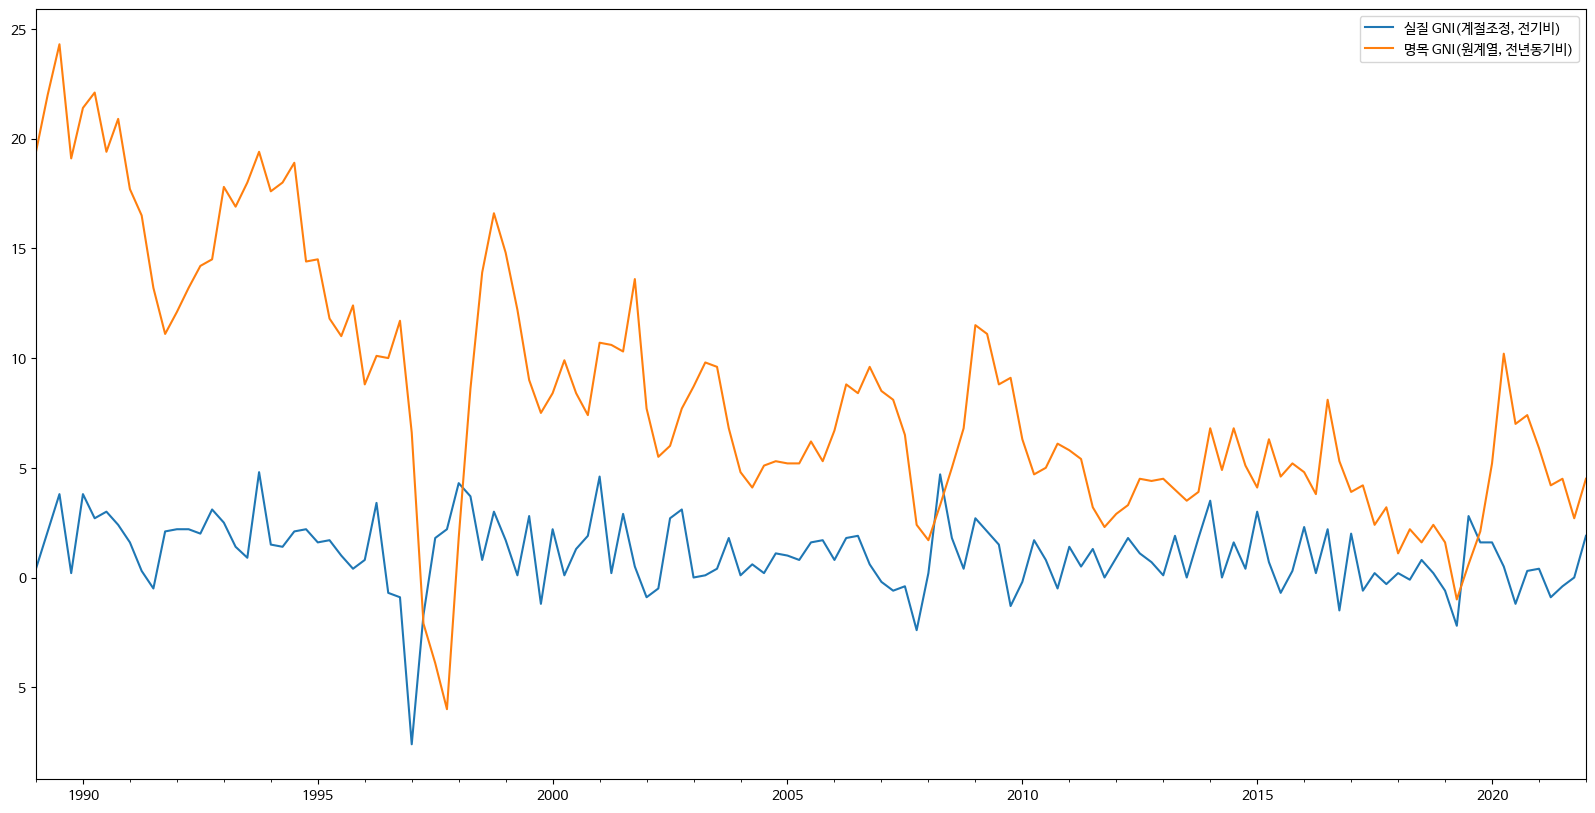

In [ ]:
globals()['df_GDP_Q_index'].iloc[120:,29:31].plot(figsize=(20,10))

<ipython-input-41-f4870879f271>:51: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout(rect=[0, 0.00, 1, 0.95]);
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


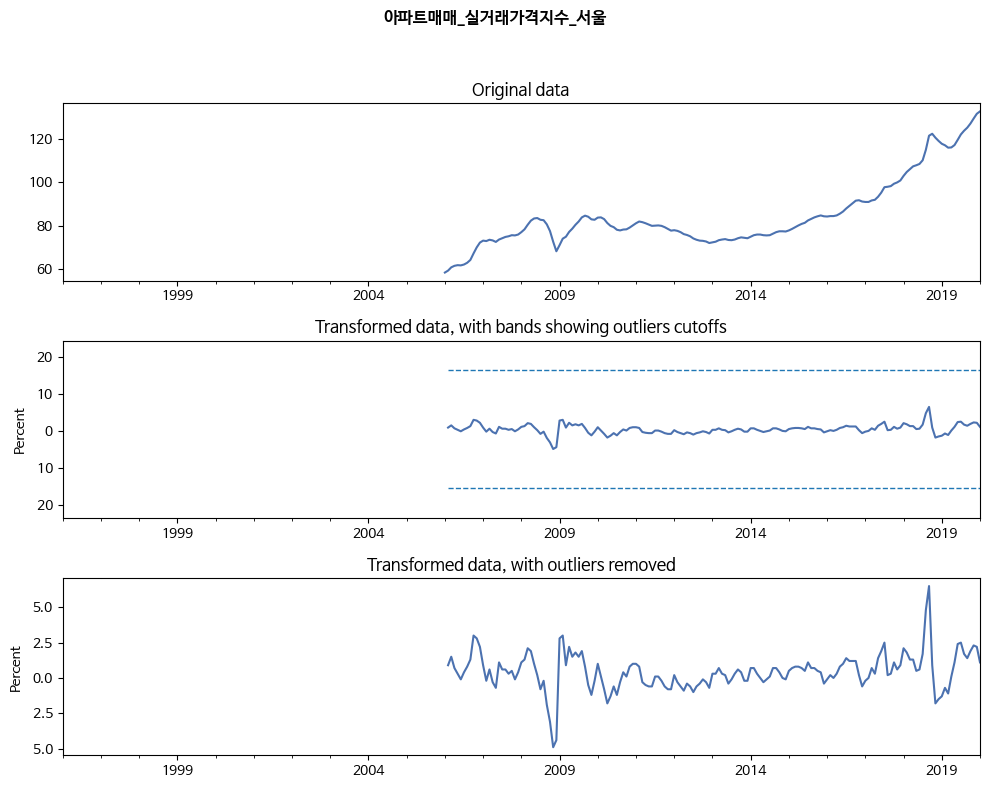

In [ ]:
with sns.color_palette('deep'):
    fig, axes = plt.subplots(3, figsize=(10, 8))

    # Plot the raw data from the February 2020 vintage, for:
    #
    vintage = 'df_house'
    variable = '아파트매매_실거래가격지수_서울'
    start = '1986-01'
    end = '2020-01'

    # 1. Plot the original dataset, for 2000-01 through 2020-01
    # globals()[vintage].loc[start:end].plot(ax=axes[0])
    globals()[vintage].loc[start:end, variable].plot(ax=axes[0])
    axes[0].set(title='Original data', xlim=('1996','2020')) #, ylabel='Billons of $')

    # 2. Plot the transformed data, still including outliers
    # (we only stored the transformation with outliers removed, so
    # here we'll manually perform the transformation)
    transformed = globals()[vintage][variable].diff().dropna()
    # transformed = globals()[vintage].diff().dropna()
    transformed.loc[start:end].plot(ax=axes[1])
    mean = transformed.mean()
    iqr = transformed.quantile([0.25, 0.75]).diff().iloc[1]
    axes[1].hlines([mean - 10 * iqr, mean + 10 * iqr],
                   transformed.index[0], transformed.index[-1],
                   linestyles='--', linewidth=1)
    axes[1].set(title='Transformed data, with bands showing outliers cutoffs',
                xlim=('1996','2020'), ylim=(mean - 15 * iqr, mean + 15 * iqr),
                ylabel='Percent')
    # axes[1].annotate('Outlier', xy=('2013-01', transformed.loc['2013-01']),
    #                  xytext=('2014-01', -5.3), textcoords='data',
    #                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)

    # 3. Plot the transformed data, with outliers removed (see missing value for 2013-01)

    mask = np.abs(transformed) > mean + 10 * iqr
    treated = transformed.copy()
    treated[mask] = np.nan

    # rm_outlier = remove_outliers(transformed)
    treated.loc[start:end].plot(ax=axes[2])
    axes[2].set(title='Transformed data, with outliers removed',
                xlim=('1996','2020'), ylabel='Percent')
    # axes[2].annotate('Missing value in place of outlier', xy=('2013-01', -1),
    #                  xytext=('2014-01', -2), textcoords='data',
    #                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))

    fig.suptitle('{}'.format(variable),
                 fontsize=12, fontweight=600)

    fig.tight_layout(rect=[0, 0.00, 1, 0.95]);

In [ ]:
# ADF TEST (Agumeted Dickey-Fuller Test)
## Stationarity Check
## (H0): non-stationary
## (H1): stationary

# def adf(time_series):
#   result =  adfuller(time_series.values)
#   print('ADF Statistic: {:4f}'.format(result[0]))
#   print('p-value: {:.4f}'.format(result[1]))

# for i in diff_data:
#   print('-Test statistic for %s' % i)
#   adf(diff_data[i])
#   print()

# '''
# --Test statistic for realgdp
# ADF Statistic: -6.9729
# p-value: 0.0000

# --Test statistic for realcons
# ADF Statistic: -4.9920
# p-value: 0.0000

# --Test statistic for realinv
# ADF Statistic: -12.2190
# p-value: 0.0000
# '''

In [ ]:
def transform(column, transforms):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if column.index.freqstr[0] == 'Q' else 1

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100

    return column


In [ ]:
def load_fredmd_data(vintage):
    base_url = 'https://s3.amazonaws.com/files.fred.stlouisfed.org/fred-md'

    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # 3. Extract the date as an index
    orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    orig_m.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m)

    # 5. Remove outliers (but not in 2020)
    dta_m.loc[:'2019-12'] = remove_outliers(dta_m.loc[:'2019-12'])

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    orig_q.drop('sasdate', axis=1, inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q)

    # 5. Remove outliers (but not in 2020)
    dta_q.loc[:'2019Q4'] = remove_outliers(dta_q.loc[:'2019Q4'])

    # - Output datasets ------------------------------------------------------
    return types.SimpleNamespace(
        orig_m=orig_m, orig_q=orig_q,
        dta_m=dta_m, transform_m=transform_m,
        dta_q=dta_q, transform_q=transform_q, factors_q=factors_q)